In [61]:
#2.3 数据加载与预处理
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import re

# 选择四个代表性的类别进行比较
categories = [
    'alt.atheism',
    'comp.graphics',
    'sci.space',
    'talk.politics.mideast'
]

# 加载数据集
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)

# 数据预处理函数
def preprocess_text(text):
    # 转换为小写
    text = text.lower()
    # 移除非字母字符
    text = re.sub(r'[^a-z\s]', '', text)
    # 移除非字母字符
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 应用预处理
processed_data = [preprocess_text(text) for text in newsgroups.data]

# 创建DataFrame
df = pd.DataFrame({
    'text': processed_data,
    'target': newsgroups.target,
    'category': [newsgroups.target_names[t] for t in newsgroups.target]
})

# 数据集统计信息
print(f"数据集大小: {len(df)}")
print(f"类别分布:\n{df['category'].value_counts()}")

# 可视化类别分布
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df)
plt.title('新闻类别分布')
plt.xlabel('类别')
plt.ylabel('文档数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

HTTPError: HTTP Error 403: Forbidden

In [41]:
#3.1.2 特征向量化实现
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['target'],
    test_size=0.2,
    random_state=42
)

# TF-IDF向量化
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 词汇表可视化
features = vectorizer.get_feature_names_out()
print(f"特征数量: {len(features)}")

# 特征降维可视化
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_train_tfidf.toarray()[:100])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train[:100], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(len(categories)))
plt.title('文本特征二维可视化 (SVD降维)')
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [ ]:
#3.2.1 支持向量机分类器
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# 创建SVM模型
svm = LinearSVC(max_iter=5000, random_state=42)

# 网格搜索优化
svm_grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)

# 最佳模型
best_svm = svm_grid.best_estimator_
print(f"最佳SVM参数: {svm_grid.best_params_}")

In [ ]:
#3.2.2 朴素贝叶斯分类器

from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

# 多项式朴素贝叶斯
nb = MultinomialNB()

# 参数搜索
param_grid_nb = {'alpha': [0.01, 0.1, 1.0]}
nb_grid = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')
nb_grid.fit(X_train_tfidf, y_train)

# 使用校准提升概率预测效果
best_nb = CalibratedClassifierCV(nb_grid.best_estimator_, cv=5, method='sigmoid')
best_nb.fit(X_train_tfidf, y_train)
print(f"最佳朴素贝叶斯参数: {nb_grid.best_params_}")

In [ ]:
#3.2.3 随机森林分类器

from sklearn.ensemble import RandomForestClassifier

# 随机森林模型
rf = RandomForestClassifier(random_state=42)

# 参数网格
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 50],
    'min_samples_split': [2, 5]
}

# 网格搜索
rf_grid = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)

best_rf = rf_grid.best_estimator_
print(f"最佳随机森林参数: {rf_grid.best_params_}")

In [ ]:
#4.1 评估指标与结果对比
from sklearn.metrics import accuracy_score, classification_report

# 模型评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=newsgroups.target_names)
    return acc, report

# 评估所有模型
svm_acc, svm_report = evaluate_model(best_svm, X_test_tfidf, y_test)
nb_acc, nb_report = evaluate_model(best_nb, X_test_tfidf, y_test)
rf_acc, rf_report = evaluate_model(best_rf, X_test_tfidf, y_test)

# 结果对比
results = pd.DataFrame({
    '模型': ['支持向量机', '朴素贝叶斯', '随机森林'],
    '准确率': [svm_acc, nb_acc, rf_acc]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='模型', y='准确率', data=results)
plt.title('不同模型在测试集上的准确率')
plt.ylim(0.6, 1.0)
for i, v in enumerate(results['准确率']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

In [ ]:
#4.2 混淆矩阵分析
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
    plt.title('混淆矩阵 (标准化)')
    plt.tight_layout()
    plt.show()

# 绘制SVM的混淆矩阵
svm_pred = best_svm.predict(X_test_tfidf)
plot_confusion_matrix(y_test, svm_pred, categories)

In [ ]:
#4.3 分类报告解读

# 打印SVM分类报告
print("支持向量机分类报告:")
print(svm_report)

# 打印各类别F1分数
report_data = []
lines = svm_report.split('\n')
for line in lines[2:-2]:
    row = line.split()
    report_data.append([row[0], float(row[1]), float(row[2]), float(row[3])])
    
report_df = pd.DataFrame(report_data, columns=['类别', '精确率', '召回率', 'F1分数'])
report_df = report_df.sort_values('F1分数', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1分数', y='类别', data=report_df, palette='viridis')
plt.title('各类别F1分数分布')
plt.xlim(0.6, 1.0)
plt.tight_layout()
plt.show()

加载IMDB电影评论数据集...
加载训练数据...
预处理数据...


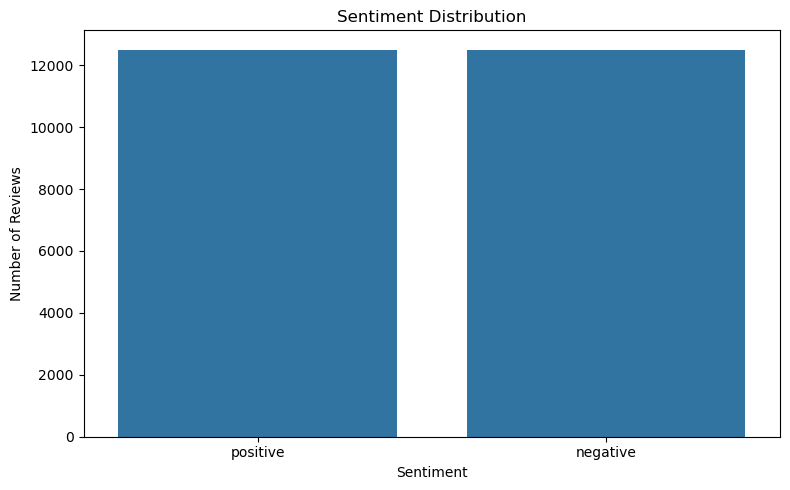

已保存类别分布图表：class_distribution.png
文本向量化...
特征数量: 5000


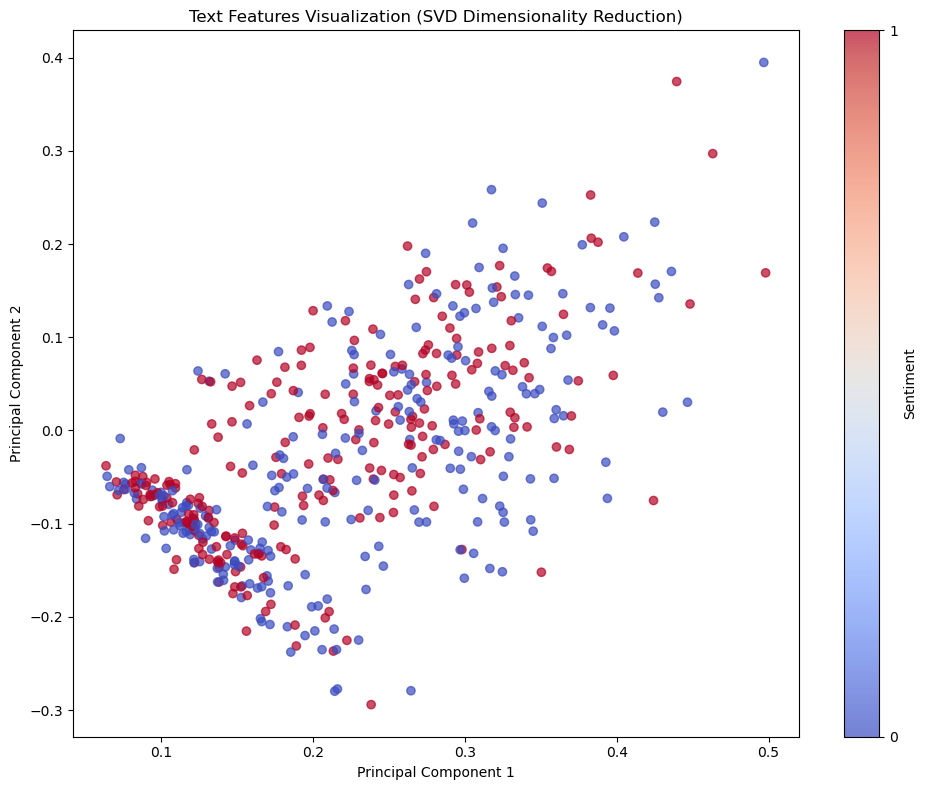

已保存特征可视化图表：feature_visualization.png
训练SVM模型...
训练朴素贝叶斯模型...
训练随机森林模型...

SVM分类报告:
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2485
    positive       0.87      0.88      0.87      2515

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



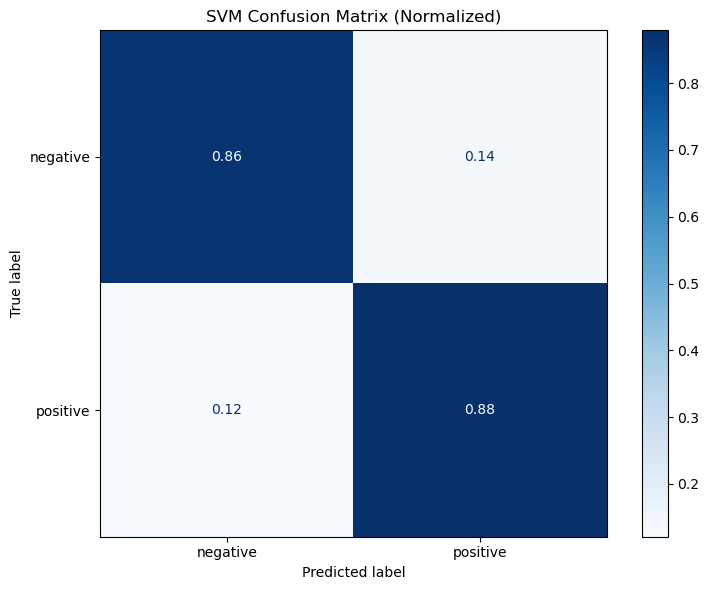

已保存SVM混淆矩阵图表：confusion_matrix_SVM.png

NaiveBayes分类报告:
              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      2485
    positive       0.85      0.86      0.85      2515

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



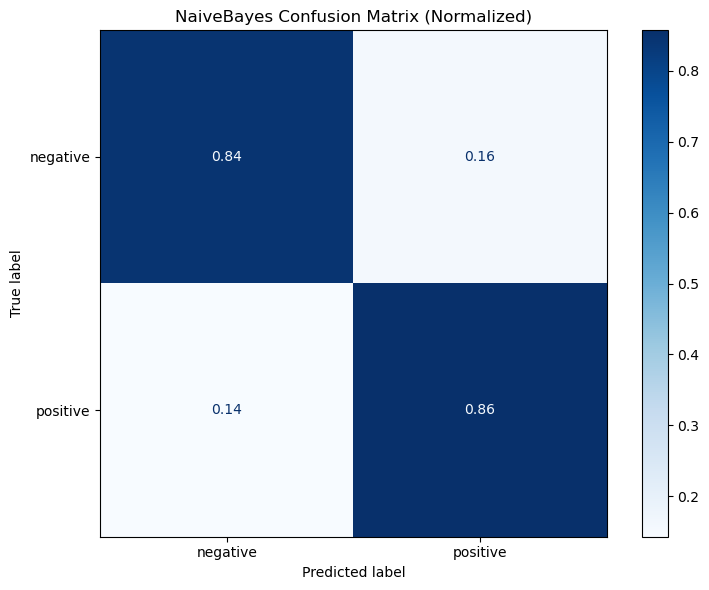

已保存NaiveBayes混淆矩阵图表：confusion_matrix_NaiveBayes.png

RandomForest分类报告:
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      2485
    positive       0.86      0.82      0.84      2515

    accuracy                           0.84      5000
   macro avg       0.85      0.85      0.84      5000
weighted avg       0.85      0.84      0.84      5000



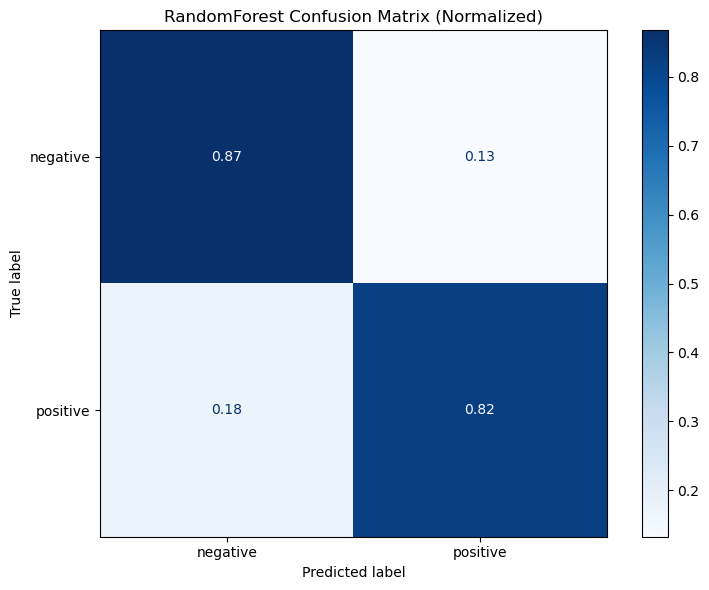

已保存RandomForest混淆矩阵图表：confusion_matrix_RandomForest.png


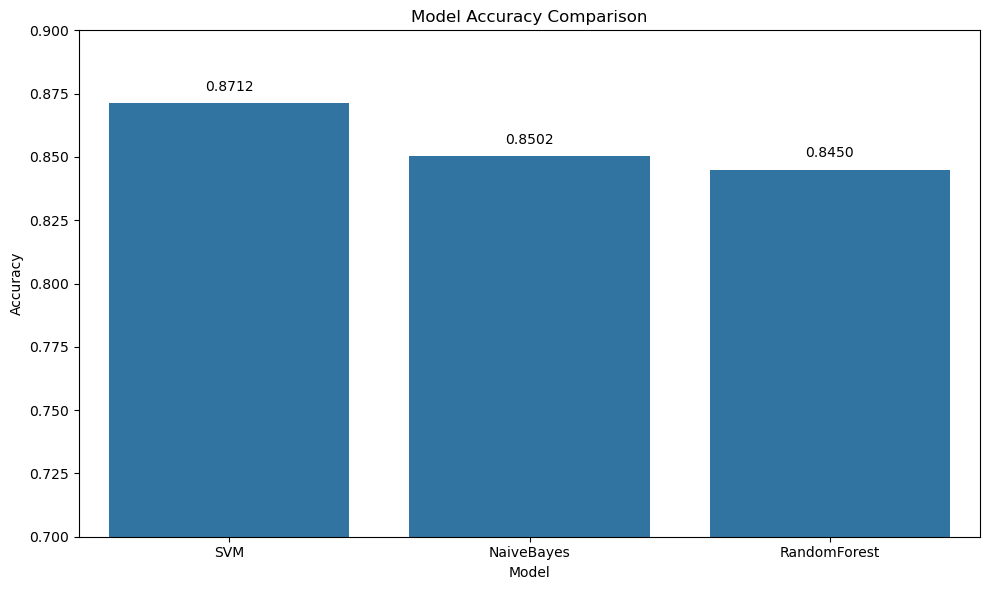

已保存准确率对比图表：accuracy_comparison.png

各类别F1分数分析(SVM模型):


C:\Users\11834\AppData\Local\Temp\ipykernel_28568\68968325.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='F1-Score', data=f1_df, order=class_names, palette='Set2')


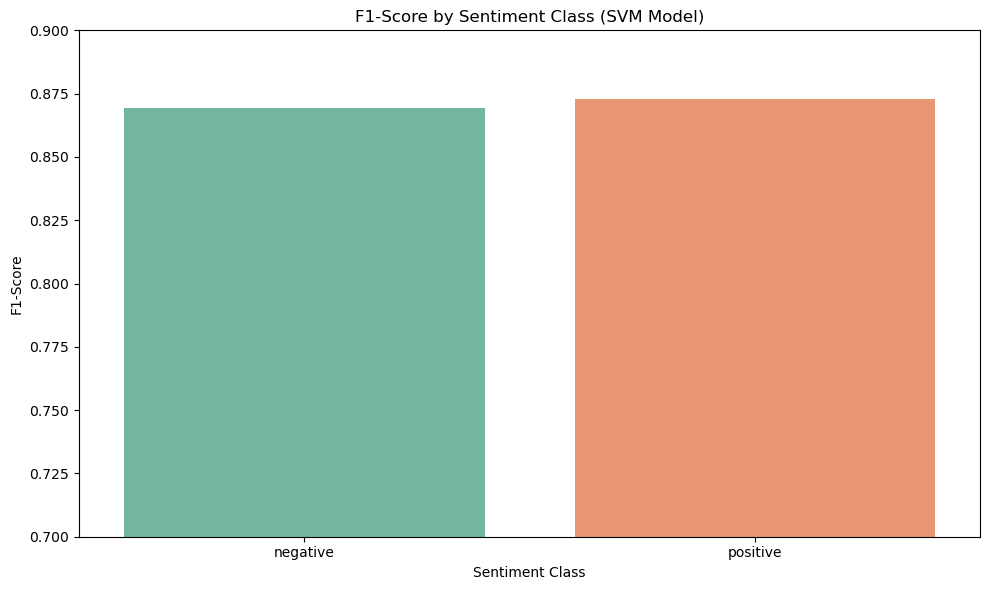

已保存F1分数分布图表：f1_scores.png

正面评论的关键词:
excellent, perfect, favorite, funniest, amazing, wonderful, great, rare, wonderfully, subtle, flawless, enjoyable, refreshing, best, entertaining

负面评论的关键词:
worst, awful, waste, disappointment, poorly, dull, disappointing, boring, worse, mstk, poor, mess, ridiculous, unfortunately, fails

样本预测测试:

样本 #1:
文本: This movie was absolutely fantastic! The acting was superb and the plot was engaging.
预测情感: positive
概率: [negative: 0.0724, positive: 0.9276]

样本 #2:
文本: I couldn't stand this film. The story was boring and the acting was terrible.
预测情感: negative
概率: [negative: 0.9836, positive: 0.0164]

样本 #3:
文本: The cinematography was beautiful but the pacing was too slow for my taste.
预测情感: positive
概率: [negative: 0.4206, positive: 0.5794]

实验完成! 所有结果已保存。


In [59]:

# 导入所需库
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import urllib.request
import tarfile

# 设置科学计算显示格式
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 200)

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# 加载IMDB电影评论数据集（情感分析）
print("加载IMDB电影评论数据集...")
def load_imdb_data():
    """
    加载IMDB电影评论数据集
    返回文本列表和标签列表
    """
    # 尝试从网络加载
    try:
        from sklearn.datasets import fetch_openml
        return fetch_openml(name='imdb_reviews', version=1, parser='auto', as_frame=False)
    except:
        # 回退方案：使用本地加载方法
        pass
    
    # 从本地加载
    data_dir = "imdb_data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        
    # 数据集URL
    train_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    train_path = os.path.join(data_dir, "aclImdb_v1.tar.gz")
    
    # 下载数据集
    if not os.path.exists(train_path):
        print("下载数据集...")
        import urllib.request
        urllib.request.urlretrieve(train_url, train_path)
    
    # 解压数据集
    extract_dir = os.path.join(data_dir, "aclImdb")
    if not os.path.exists(extract_dir):
        print("解压数据集...")
        import tarfile
        with tarfile.open(train_path, 'r:gz') as tar:
            # 添加filter参数解决Python 3.14的警告
            tar.extractall(path=data_dir, filter='data')
    
    # 加载训练数据
    print("加载训练数据...")
    reviews = []
    labels = []
    
    # 加载正面评论
    pos_dir = os.path.join(extract_dir, "train", "pos")
    for filename in os.listdir(pos_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(pos_dir, filename), 'r', encoding='utf-8', errors='ignore') as f:
                reviews.append(f.read())
                labels.append(1)  # 1表示正面评论
    
    # 加载负面评论
    neg_dir = os.path.join(extract_dir, "train", "neg")
    for filename in os.listdir(neg_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(neg_dir, filename), 'r', encoding='utf-8', errors='ignore') as f:
                reviews.append(f.read())
                labels.append(0)  # 0表示负面评论
    
    # 返回数据集
    return {'data': np.array(reviews), 'target': np.array(labels)}

# 加载数据集
imdb = load_imdb_data()
data = imdb['data']
targets = imdb['target']

# 创建DataFrame
df = pd.DataFrame({
    'text': data,
    'target': targets
})

# 标签映射
sentiment_map = {0: 'negative', 1: 'positive'}
df['sentiment'] = df['target'].map(sentiment_map)

# 数据预处理函数
def preprocess_text(text):
    # 转换为小写
    text = text.lower()
    # 移除非字母字符（保留基本标点）
    text = re.sub(r'[^a-z\s.,?!;\'"]', '', text)
    # 减少连续空格
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 应用预处理
print("预处理数据...")
df['clean_text'] = df['text'].apply(preprocess_text)

# 可视化类别分布 - 使用英文标签
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()
print("已保存类别分布图表：class_distribution.png")

# 特征工程 - 文本向量化
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], 
    df['target'],
    test_size=0.2,
    random_state=42
)

print("文本向量化...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"特征数量: {len(vectorizer.get_feature_names_out())}")

# 特征降维可视化 - 使用英文标签
svd = TruncatedSVD(n_components=2, random_state=42)
# 只处理前500个样本以避免内存问题
X_2d = svd.fit_transform(X_train_tfidf[:500].toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train[:500], cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Sentiment')
plt.title('Text Features Visualization (SVD Dimensionality Reduction)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('feature_visualization.png')
plt.show()
print("已保存特征可视化图表：feature_visualization.png")

# 模型训练
print("训练SVM模型...")
svm = LinearSVC(max_iter=5000, random_state=42, C=1.0, dual='auto')
svm.fit(X_train_tfidf, y_train)
best_svm = svm

print("训练朴素贝叶斯模型...")
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_tfidf, y_train)
best_nb = CalibratedClassifierCV(nb, cv=3, method='sigmoid')
best_nb.fit(X_train_tfidf, y_train)

print("训练随机森林模型...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
best_rf = rf

# 模型评估函数 - 修复关键词提取问题
def evaluate_model(model, model_name, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_names)
    
    print(f"\n{model_name}分类报告:")
    print(report)
    
    # 保存报告
    with open(f'classification_report_{model_name}.txt', 'w') as f:
        f.write(report)
    
    # 绘制混淆矩阵 - 使用英文标签
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax)
    plt.title(f'{model_name} Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300)
    plt.show()
    print(f"已保存{model_name}混淆矩阵图表：confusion_matrix_{model_name}.png")
    
    return acc, report, y_pred

# 评估所有模型
class_names = ['negative', 'positive']
svm_acc, svm_report, svm_pred = evaluate_model(best_svm, "SVM", X_test_tfidf, y_test, class_names)
nb_acc, nb_report, nb_pred = evaluate_model(best_nb, "NaiveBayes", X_test_tfidf, y_test, class_names)
rf_acc, rf_report, rf_pred = evaluate_model(best_rf, "RandomForest", X_test_tfidf, y_test, class_names)

# 结果对比
results = pd.DataFrame({
    'Model': ['SVM', 'NaiveBayes', 'RandomForest'],
    'Accuracy': [svm_acc, nb_acc, rf_acc]
})

# 准确率对比图表 - 使用英文标签
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 0.9)
for i, v in enumerate(results['Accuracy']):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300)
plt.show()
print("已保存准确率对比图表：accuracy_comparison.png")

# 分析各类别F1分数 - 修复处理分类报告的问题
print("\n各类别F1分数分析(SVM模型):")
from sklearn.metrics import classification_report
import pandas as pd

# 生成分类报告字典
svm_report_dict = classification_report(y_test, svm_pred, target_names=class_names, output_dict=True)

# 创建DataFrame
f1_data = []
for class_name in class_names:
    f1_data.append({
        'Category': class_name,
        'F1-Score': svm_report_dict[class_name]['f1-score']
    })
f1_df = pd.DataFrame(f1_data)

# F1分数分布图表 - 使用英文标签
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='F1-Score', data=f1_df, order=class_names, palette='Set2')
plt.title('F1-Score by Sentiment Class (SVM Model)')
plt.ylim(0.7, 0.9)
plt.xlabel('Sentiment Class')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.savefig('f1_scores.png', dpi=300)
plt.show()
print("已保存F1分数分布图表：f1_scores.png")

# 关键词分析 - 修复索引越界问题
def get_top_keywords(vectorizer, model, class_index, n=10):
    feature_names = vectorizer.get_feature_names_out()
    if hasattr(model, 'coef_'):
        # 二分类问题中coef_只有一行
        coef = model.coef_[0] if model.coef_.shape[0] == 1 else model.coef_[class_index]
        
        # 获取关键词索引 - 针对二分类进行调整
        if model.coef_.shape[0] == 1:  # 二分类问题
            if class_index == 1:  # 正面评论
                top_indices = np.argsort(coef)[-n:][::-1]
            else:  # 负面评论
                top_indices = np.argsort(coef)[:n]
        else:  # 多分类问题
            top_indices = np.argsort(coef)[-n:][::-1]
            
        return [feature_names[i] for i in top_indices]
    else:
        return ["N/A for this model"]

print("\n正面评论的关键词:")
positive_keywords = get_top_keywords(vectorizer, best_svm, 1, 15)
print(', '.join(positive_keywords))

print("\n负面评论的关键词:")
negative_keywords = get_top_keywords(vectorizer, best_svm, 0, 15)
print(', '.join(negative_keywords))

# 样本预测展示
def predict_sample(model, vectorizer, text):
    cleaned = preprocess_text(text)
    vector = vectorizer.transform([cleaned])
    pred = model.predict(vector)[0]
    proba = model.predict_proba(vector)[0] if hasattr(model, 'predict_proba') else None
    return pred, proba

print("\n样本预测测试:")
sample_texts = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "I couldn't stand this film. The story was boring and the acting was terrible.",
    "The cinematography was beautiful but the pacing was too slow for my taste."
]

for i, text in enumerate(sample_texts):
    pred, proba = predict_sample(best_nb, vectorizer, text)
    sentiment = "positive" if pred == 1 else "negative"
    print(f"\n样本 #{i+1}:\n文本: {text}\n预测情感: {sentiment}")
    if proba is not None:
        print(f"概率: [negative: {proba[0]:.4f}, positive: {proba[1]:.4f}]")

# 保存完整结果
df.to_csv('imdb_dataset.csv', index=False)
results.to_csv('model_results.csv', index=False)

print("\n实验完成! 所有结果已保存。")
